In [1]:
# import IPython
# import soundfile as sf
# from tango import Tango

# tango = Tango("declare-lab/tango2-full", device="cuda:2")

# prompt = "A cat meowing and an audience cheering and clapping"
# audio = tango.generate(prompt)
# sf.write(f"{prompt}.wav", audio, samplerate=16000)
# IPython.display.Audio(data=audio, rate=16000)

In [2]:
device = "cuda:0"

In [6]:
import os
import torch
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from tango import Tango
import sys; sys.path.append("/workspace/DGMO-Separation")  # 예: "/home/user/myproject"
from src.utils import load_config, save_wav_file, AudioDataProcessor
import csv
from tqdm import tqdm
from contextlib import redirect_stdout
from src.models import AudioLDM  # 0.18.2 -> 0.32.2

"""
inv_text=[prompt],
text=[prompt],
ddim_steps=400,
timestep_level=0.8,
guidance_scale=3,
batch_size=2,
duration=10.24,
# 'SDR': 34.39
# 'SI-SDR': -109.87
# 'SDRi': 26.53
# 'SI-SDRi': -108.76

inv_text=[prompt],
text=[prompt],
ddim_steps=150,
timestep_level=0.8,
guidance_scale=3,
batch_size=2,
duration=10.24,
# SDR: 22.48
# SDRi: -121.79
# SI-SDR: 16.24
# SI-SDRi: -119.06

-4.02, 1.82
-4.99, 1.57
SDR: 6.94
SDRi: -137.13
SI-SDR: -5.05
SI-SDRi: -141.45
"""

def plot_mel_raw(mel_list, save_path="./mel_raw.png"):
    """
    mel_list: list of 2 mel tensors or arrays. Each should be shape (T, F) or similar.
    """
    assert len(mel_list) == 2, "mel_list must contain exactly two items"

    def preprocess(mel):
        if isinstance(mel, torch.Tensor):
            mel = mel.detach().cpu().numpy()
        mel = np.squeeze(mel)
        if mel.ndim == 3:
            mel = mel[0]
        if mel.shape[0] > mel.shape[1]:  # (T, F) → (F, T)
            mel = mel.T
        return mel

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    names = ["Original", "Reconstructed"]

    for i in range(2):
        mel = preprocess(mel_list[i])
        axes[i].imshow(mel, aspect='auto', origin='lower', cmap='inferno')
        axes[i].set_title(f"{names[i]} Mel")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Mel bins")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

def si_sdr(reference, estimation, eps=1e-8):
    reference = reference - reference.mean()
    estimation = estimation - estimation.mean()

    alpha = torch.sum(reference * estimation) / (torch.sum(reference ** 2) + eps)
    projected = alpha * reference

    noise = estimation - projected
    ratio = torch.sum(projected ** 2) / (torch.sum(noise ** 2) + eps)
    return 10 * torch.log10(ratio + eps)

def sdr(reference, estimation, eps=1e-8):
    noise = reference - estimation
    ratio = torch.sum(reference ** 2) / (torch.sum(noise ** 2) + eps)
    return 10 * torch.log10(ratio + eps)

def compute_metrics(mixture, reference, estimation):
    sdr_est = sdr(reference, estimation)
    sdr_mix = sdr(reference, mixture)
    sdr_i = sdr_est - sdr_mix

    si_sdr_est = si_sdr(reference, estimation)
    si_sdr_mix = si_sdr(reference, mixture)
    si_sdr_i = si_sdr_est - si_sdr_mix

    return {
        "SDR": sdr_est.item(),
        "SDRi": sdr_i.item(),
        "SI-SDR": si_sdr_est.item(),
        "SI-SDRi": si_sdr_i.item()
    }

with open(os.devnull, 'w') as f, redirect_stdout(f):
    tango = Tango("declare-lab/tango2-full", device=device)
    # tango = AudioLDM(ckpt="cvssp/audioldm", device=device,)
    # tango.eval()  ##
    # for param in tango.parameters():
    #     param.requires_grad = False  # 모든 가중치가 학습되지 않음
"declare-lab/tango2-full"

Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 85948.85it/s]
Some weights of the model checkpoint at google/flan-t5-large were not used when initializing T5EncoderModel: ['decoder.block.12.layer.0.SelfAttention.k.weight', 'decoder.block.17.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.22.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.3.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.17.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.16.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.20.layer.2.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.11.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.11.layer.0.SelfAttention.o.weight', 'decoder.block.18.layer.2.layer_norm.weight', 'decoder.block.23.layer.0.SelfAttention.q.weight', 'decoder.block.15.layer.2.DenseReluDense.wo.weight', 'decoder.block.21.layer.0.SelfAttention.o.weight'

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login`.

In [ ]:
processor = AudioDataProcessor(config_path="../configs/audioldm.yaml", device=device)

metadata_pth=f'../src/benchmarks/metadata/audiocaps_eval.csv'
with open(metadata_pth) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    eval_list = [row for row in csv_reader][1:]
# for eval_data in tqdm(eval_list[:100]):
idx, caption, labels, src_wav, noise_wav = eval_list[2]

print(f"""
idx:       {idx}
caption:   {caption}
labels:    {labels}
src_wav:   {src_wav}
noise_wav: {noise_wav}
""")

batch=4
audio_dir=f'../data/audiocaps'
mixture_path = os.path.join(audio_dir, f'mixture-{idx}.wav')
source_path = os.path.join(audio_dir, f'segment-{idx}.wav')
# mixture_path = "./An audience cheering and clapping and a cat meowing.wav"
# source_path = "./An audience cheering and clapping and a cat meowing.wav"


src_wav = processor.read_wav_file(source_path)
src_wav_norm = processor.prepare_wav(src_wav, reconstruction=False)
src_stft_mag, src_stft_complex = processor.wav_to_stft(src_wav_norm)
src_mel = processor.stft_to_mel(src_stft_mag)
src_input = processor.preprocess_spec(src_mel)
src_inputs = src_input.repeat(batch, 1, 1, 1)

mix_wav = processor.read_wav_file(mixture_path)
mix_wav_norm = processor.prepare_wav(mix_wav)
mix_stft_mag, mix_stft_complex = processor.wav_to_stft(mix_wav_norm)
cur_mel = processor.stft_to_mel(mix_stft_mag)
vae_input = processor.preprocess_spec(cur_mel)
vae_inputs = vae_input.repeat(batch, 1, 1, 1)
with open(os.devnull, 'w') as f, redirect_stdout(f):
    recon_vae_inputs = tango.edit(
        mel=vae_inputs,
        inv_text=[""],
        text=[caption],
        ddim_steps=25,
        timestep_level=0.7,
        guidance_scale=7,
        batch_size=batch,
        duration=10.24,
    )

print("")
print(f"원본 mean, vae: {vae_inputs.mean().item():.2f}, {vae_inputs.std().item():.2f}")
print(f"참조 mean, vae: {recon_vae_inputs.mean().item():.2f}, {recon_vae_inputs.std().item():.2f}\n")

dic = compute_metrics(vae_inputs, src_inputs, recon_vae_inputs)
for k,v in dic.items():
    print(f"{k}: {v:.2f}")
# plot_mel_raw([vae_inputs, recon_vae_inputs])

  0%|          | 0/24 [00:00<?, ?it/s]

[INFO] audio_processing.py: Prepared Settings for cvssp/audioldm

idx:       2
caption:   Humming and vibrating with a man and children speaking and laughing
labels:    Train Speech Child speech, kid speaking
src_wav:   YGOD8Bt5LfDE.wav
noise_wav: Ygf6H_MWCqjw.wav



100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


원본 mean, vae: -5.09, 1.69
참조 mean, vae: -3.15, 2.77

SDR: 4.77
SDRi: -9.43
SI-SDR: -4.52
SI-SDRi: -6.91


: 

In [18]:
import IPython
wave = tango.vae.decode_to_waveform(vae_inputs)
IPython.display.Audio(data=wave, rate=16000)

In [25]:
import IPython

def match_mean_var(feat_src, feat_ref, eps=1e-5):
    mean_src = feat_src.mean()
    std_src = feat_src.std()

    mean_ref = feat_ref.mean()
    std_ref = feat_ref.std()

    # z-score normalization 후 기준 통계로 rescale
    normalized = (feat_src - mean_src) / (std_src + eps)
    matched = normalized * std_ref + mean_ref
    return matched

def match_min_max(feat_src, feat_ref, eps=1e-5):
    min_ref = feat_ref.min()
    max_ref = feat_ref.max()

    min_src = feat_src.min()
    max_src = feat_src.max()

    # [0,1]로 정규화 후 ref 기준 범위로 rescale
    normalized = (feat_src - min_src) / (max_src - min_src + eps)
    matched = normalized * (max_ref - min_ref) + min_ref
    return matched

def rms(mel_src, mel_ref):
    scale = (mel_ref**2).mean().sqrt() / (mel_src**2).mean().sqrt()
    return scale * mel_src

ref_mels = recon_vae_inputs - 2
# wave = tango.vae.decode_to_waveform(ref_mels)
# IPython.display.Audio(data=wave, rate=16000)

In [29]:
import IPython
import torch
import torch.nn as nn
import torch.optim as optim
# from src.models import AudioLDM, AudioLDM2, Auffusion, 
from src.models import Mask, Multi_Class_Mask
from src.utils import load_config, save_wav_file, AudioDataProcessor


def inference(
            processor: AudioDataProcessor,
            mix_stft_mag: str = None,
            mix_stft_complex: str = None,
            ref_mels: str = None,
            batch=4,
            thresholding=True,
            ):

        iteration=1
        epochs=300
        learning_rate=0.01

        mask = Mask(channel=1,
            height=processor.n_freq_bins,
            width=processor.n_time_frames,
            device=processor.device)
        optimizer = optim.Adam(mask.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        for iter in range(iteration):

            assert ref_mels.size(0) == batch and ref_mels.dim() == 4,\
                (ref_mels.shape, batch)
            # ------- Mask Optimization ------- #
            loss_values = []
            for epoch in range(epochs):
                optimizer.zero_grad()
                assert mix_stft_mag.shape == mask().detach().clone().shape, (mix_stft_mag.shape, mask().detach().clone().shape)
                masked_stft = mix_stft_mag * mask()  #ts[1,513,1024]
                masked_mel = processor.stft_to_mel(masked_stft)  # [1,M,T]
                msked_vae_mel = processor.preprocess_spec(masked_mel)  # [1,1,T*,M*]
                msked_vae_mels = msked_vae_mel.repeat(batch, 1, 1, 1)

                # ref_mels = match_mean_var(ref_mels, msked_vae_mels.clone().detach())

                loss = criterion(ref_mels, msked_vae_mels)
                loss.backward()
                optimizer.step()
                loss_values.append(loss.item())
            
            with torch.no_grad():
                final_mask = mask().detach().clone()
                assert final_mask.max() <= 1.0 and final_mask.min() >= 0.0, (final_mask.max(), final_mask.min())
                if thresholding:
                    threshold = 0.8
                    final_mask[final_mask >= threshold] = 1.0
                cur_stft_mag = mix_stft_mag * final_mask  #ts[1,513,1024]
                
        msked_wav = processor.inverse_stft(cur_stft_mag, mix_stft_complex)
        return msked_wav, ref_mels  # np[1,N]

msked_wav, ref_mels = inference(
    processor=processor,
    mix_stft_mag=mix_stft_mag,
    mix_stft_complex=mix_stft_complex,
    ref_mels=ref_mels,
    batch=batch,
    thresholding=False
)

msked_wav_norm = processor.prepare_wav(msked_wav)
msked_stft_mag, msked_stft_complex = processor.wav_to_stft(msked_wav_norm)
cur_mel_ = processor.stft_to_mel(msked_stft_mag)
vae_input_ = processor.preprocess_spec(cur_mel_)
vae_inputs_ = vae_input_.repeat(batch, 1, 1, 1)

IPython.display.Audio(data=msked_wav, rate=16000)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
if vae_inputs.dim() == 4:
    vae_inputs = vae_inputs.detach().cpu().numpy().mean(axis=0)[0]
    ref_mels_post = ref_mels.detach().cpu().numpy().mean(axis=0)[0]
    vae_inputs_post = vae_inputs_.detach().cpu().numpy().mean(axis=0)[0]
    src_inputs = src_inputs.detach().cpu().numpy().mean(axis=0)[0]

    vae_inputs = torch.from_numpy(vae_inputs)
    ref_mels_post = torch.from_numpy(ref_mels_post)
    vae_inputs_post = torch.from_numpy(vae_inputs_post)
    src_inputs = torch.from_numpy(src_inputs)

print("원본이랑 masked 비교")
plot_mel_raw([vae_inputs, vae_inputs_post])
print("ref랑 masked 비교")
plot_mel_raw([ref_mels_post, vae_inputs_post])

def plot_mel_diff(mel1, mel2, save_path="./mel_diff.png"):
    def preprocess(mel):
        if isinstance(mel, torch.Tensor):
            mel = mel.detach().cpu().numpy()
        mel = np.squeeze(mel)
        if mel.ndim == 3:
            mel = mel[0]
        if mel.shape[0] > mel.shape[1]:  # (T, F) → (F, T)
            mel = mel.T
        return mel

    mel1 = preprocess(mel1)
    mel2 = preprocess(mel2)
    diff = mel1 - mel2  # element-wise difference

    print(f"최대: {diff.max():.2f}\n최소: {diff.min():.2f}")

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(diff, aspect='auto', origin='lower', cmap='bwr')  # bwr: blue-white-red
    ax.set_title("Mel Difference (Original - Reconstructed)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel bins")

    # colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Difference")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

print("원본이랑 ref 비교")
plot_mel_diff(vae_inputs, ref_mels_post)
print("원본이랑 masked 비교")
plot_mel_diff(vae_inputs, vae_inputs_post)

def plot_mel_spec_stats(spec1: np.ndarray, spec2: np.ndarray, labels=('Spec 1', 'Spec 2')):
    def compute_stats(spec):
        flat = spec.flatten()
        return {
            'min': flat.min(),
            'max': flat.max(),
            'mean': flat.mean(),
            'std': flat.std()
        }

    stats1 = compute_stats(spec1)
    stats2 = compute_stats(spec2)

    fig, ax = plt.subplots(figsize=(15, 2))
    y1, y2 = 0.9, 1.1  # y축 위치 (이제 세로 방향 분리)

    # Spec 1
    ax.hlines(y1, stats1['min'], stats1['max'], color='blue', linewidth=5, label=labels[0])
    ax.plot(stats1['mean'], y1, 'o', color='black')  # mean
    ax.errorbar(stats1['mean'], y1, xerr=stats1['std'], fmt='none', ecolor='black', capsize=5)

    # Spec 2
    ax.hlines(y2, stats2['min'], stats2['max'], color='red', linewidth=5, label=labels[1])
    ax.plot(stats2['mean'], y2, 'o', color='black')  # mean
    ax.errorbar(stats2['mean'], y2, xerr=stats2['std'], fmt='none', ecolor='black', capsize=5)

    ax.set_yticks([y1, y2])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Value')
    ax.set_title('Mel Spectrogram Statistics')
    ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

plot_mel_spec_stats(vae_inputs, ref_mels_post, labels=('Original', 'Reconstructed'))
plot_mel_spec_stats(vae_inputs, vae_inputs_post, labels=('Original', 'Masked'))

dic = compute_metrics(vae_inputs_post, src_inputs, ref_mels_post)
for k,v in dic.items():
    print(f"{k}: {v:.2f}")


TypeError: expected np.ndarray (got numpy.float32)

In [ ]:
prompts = [caption,
          caption,
          caption,
          caption,]
wavs = []
mels = []
for prompt in prompts:
    audio_wav, mel = tango.generate(prompt)
    mel = torch.from_numpy(mel.detach().cpu().numpy().mean(axis=0)[0])
    print(mel.shape)
    mels.append(mel)


torch.Size([1, 8, 256, 16])
torch.Size([1, 1, 1024, 64])
torch.Size([1024, 64])
torch.Size([1, 8, 256, 16])
torch.Size([1, 1, 1024, 64])
torch.Size([1024, 64])
torch.Size([1, 8, 256, 16])
torch.Size([1, 1, 1024, 64])
torch.Size([1024, 64])
torch.Size([1, 8, 256, 16])
torch.Size([1, 1, 1024, 64])
torch.Size([1024, 64])


: 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

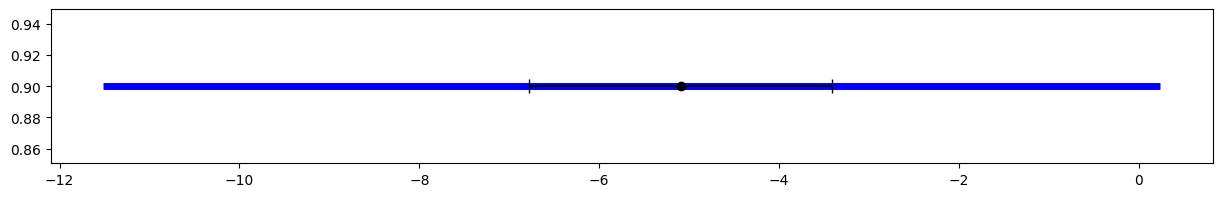

In [13]:
plot_mel_spec_stats(vae_inputs, ref_mels, labels=('Original', 'Reconstructed'))
plot_mel_spec_stats(vae_inputs, mels[0], labels=('Original', 'Masked[0]'))
plot_mel_spec_stats(vae_inputs, mels[1], labels=('Original', 'Masked[1]'))
plot_mel_spec_stats(mels[2], mels[3], labels=('Masked[2]', 'Masked[3]'))
plot_mel_raw([mels[0], mels[1]])
plot_mel_raw([mels[2], mels[3]])

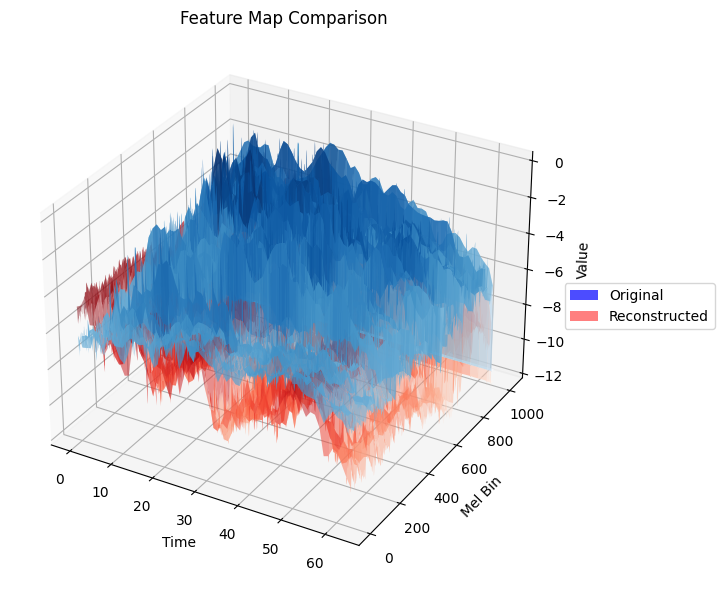

AssertionError: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_2d_feature_comparison(original: np.ndarray, recon: np.ndarray, base_z=-12):
    assert original.shape == recon.shape
    H, W = original.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))  # (T, mel_bin)
    Z1 = original
    Z2 = recon

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 원본 feature map
    ax.plot_surface(X, Y, Z1, cmap='Blues', alpha=0.7, edgecolor='none', label='Original')

    # 재구성된 feature map
    ax.plot_surface(X, Y, Z2, cmap='Reds', alpha=0.5, edgecolor='none', label='Reconstructed')

    # 기준 평면
    ax.set_zlim(base_z, max(Z1.max(), Z2.max()))
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Bin')
    ax.set_zlabel('Value')
    ax.set_title('Feature Map Comparison')

    # 범례는 직접 수동으로 추가
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Original'),
        Patch(facecolor='red', alpha=0.5, label='Reconstructed')
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()

plot_2d_feature_comparison(vae_inputs, ref_mels_post)
plot_2d_feature_comparison(vae_inputs, vae_inputs_)


In [ ]:
# for i in range(5):
#     re_vae_inputs = tango.edit(
#             mel=recon_vae_inputs,
#             inv_text=[prompt],
#             text=[prompt],
#             duration=10.24,
#             batch_size=2,
#             timestep_level=0.2,
#             guidance_scale=3,
#             ddim_steps=50,
#         )
#     plot_mel_raw([vae_inputs, re_vae_inputs])
#     plot_mel_diff(vae_inputs, re_vae_inputs)


: 

: 

: 